# K-Means Clustering using PCA-transformed data

This notebook uses data that has been transformed using Principal Component Analysis (PCA) to estimate a number of clusters in the data by the K-Means method.  Best number of clusters will be chosen according to the "elbow method."

If this technique suggests a relatively small number of clusters, we will use them as a class marker for each company, augmenting the data that we feed to our supervised models.

In [1]:
#123456789012345678901234567890123456789012345678901234567890123456789012345678

In [2]:
import sys
PATH_TO_MODULES = '../../..'
sys.path.insert(0, PATH_TO_MODULES)

from helpers import *
from unsupervised_helpers import *

# Data Manipulation and Math/Stats Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import altair as alt

In [3]:
from sklearn.cluster import DBSCAN


## Load data and check for missing values

*credit to [Michael P. Notter](https://miykael.github.io/blog/2022/advanced_eda/) for sharing these techniques!*

In [4]:
# Import merged dataset
path = PATH_TO_MODULES + '/datasets/'
input_filename = 'X_train_filled_KPIs_QoQ.csv'
dataset = pd.read_csv(path + input_filename)
if 'Unnamed: 0' in dataset.columns:
    dataset.drop(columns=['Unnamed: 0'], inplace=True)
print(f'There are {dataset.shape[0]} rows and {dataset.shape[1]} columns in the dataset.')

There are 1910 rows and 265 columns in the dataset.


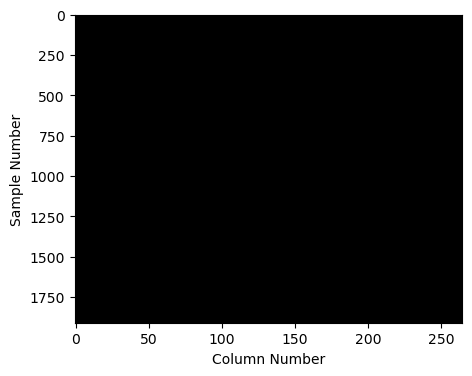

In [5]:
# Missing values show in white in the figure
plt.figure(figsize=(5, 4))
plt.imshow(dataset.isna(), aspect='auto', interpolation='nearest', cmap='gray')
plt.xlabel('Column Number')
plt.ylabel('Sample Number')
plt.show()

In [6]:
# List features missing the most data
dataset.isna().mean().sort_values(ascending=False)[:5]

IncomeTaxExpense_Rate        0.0
Ticker                       0.0
Name                         0.0
Sector                       0.0
CapitalExpenditure_2024Q2    0.0
dtype: float64

## Process for PCA, apply K-Means clustering

In [7]:
pca_df = process_for_PCA(dataset)

In [8]:
# From previous exploration, we found that the top 50 PCs explain 85% variance
pca = PCA(50)
X_PCA = pca.fit_transform(pca_df)

In [9]:
# Try different numbers of clusters; record results
wgss = get_wgss(X_PCA, max_clusters=40)

100%|███████████████████████████████████████████| 40/40 [00:17<00:00,  2.23it/s]


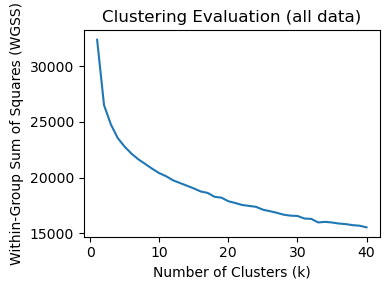

WGSS at 7 clusters: 21624


In [10]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (all data)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss[7])}')

### Try different subsets of the variables

Let's see if our derived features manage to capture the variance more efficiently.  We will examine the key performance indicators (KPI), the quarterly rates of change (QoQ), and the macroeconomic variables (Macro).

#### First examine all subsets combined: KPI, QoQ, Macro

In [11]:
# Create subset of all derived features and process for PCA
subset_df = pd.concat(
    (get_KPI(dataset), get_Rate(dataset), get_Macro(dataset)),
    axis=1
)
pca_df = process_for_PCA(subset_df)
X_PCA = pca.fit_transform(pca_df)

In [12]:
wgss = get_wgss(X_PCA, max_clusters=40)

100%|███████████████████████████████████████████| 40/40 [00:19<00:00,  2.05it/s]


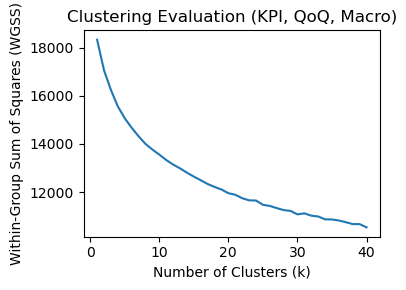

WGSS at 7 clusters: 14318


In [13]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (KPI, QoQ, Macro)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss[7])}')

#### Cluster by KPIs only

In [14]:
# Create KPI subset and process for PCA
subset_df = get_KPI(dataset)
pca_df = process_for_PCA(subset_df)
pca_KPI = PCA(10)
X_PCA_KPI = pca_KPI.fit_transform(pca_df)

In [15]:
wgss = get_wgss(X_PCA_KPI, max_clusters=40)

100%|███████████████████████████████████████████| 40/40 [00:12<00:00,  3.08it/s]


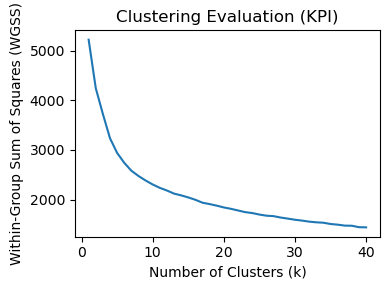

WGSS at 7 clusters: 2581


In [16]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (KPI)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss[7])}')

#### Cluster by rates of change (QoQ, etc.) only

In [17]:
# Create Rate subset and process for PCA
subset_df = get_Rate(dataset)
pca_df = process_for_PCA(subset_df)
X_PCA = pca.fit_transform(pca_df)

In [18]:
wgss = get_wgss(X_PCA, max_clusters=40)

100%|███████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


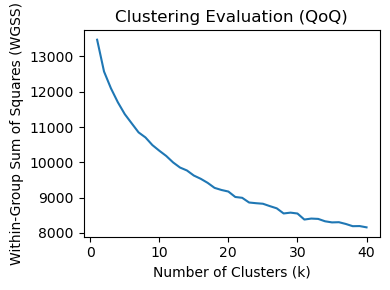

WGSS at 7 clusters: 10847


In [19]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (QoQ)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss[7])}')

#### Cluster by KPI and Macro

In [20]:
# Create subset of KPI and macroeconomic features; process for PCA
KPI_macro_df = pd.concat((get_KPI(dataset), get_Macro(dataset)), axis=1)
KPI_macro_pca_df = process_for_PCA(KPI_macro_df)
KPI_macro_pca = PCA(10)
X_KPI_macro_PCA = KPI_macro_pca.fit_transform(KPI_macro_pca_df)

In [21]:
wgss_KPI_macro = get_wgss(X_KPI_macro_PCA, max_clusters=40)

100%|███████████████████████████████████████████| 40/40 [00:12<00:00,  3.08it/s]


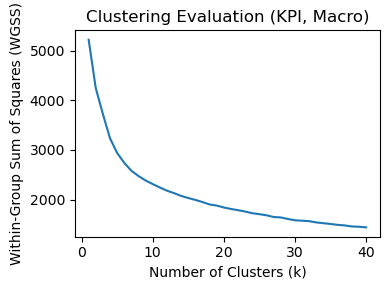

WGSS at 7 clusters: 10847


In [22]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss_KPI_macro.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (KPI, Macro)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss_KPI_maco[7])}')

#### Cluster by Rate and Macro

In [23]:
# Create subset of Rate and macroeconomic features; process for PCA
subset_df = pd.concat((get_Rate(dataset), get_Macro(dataset)), axis=1)
pca_df = process_for_PCA(subset_df)
X_PCA = pca.fit_transform(pca_df)

In [24]:
wgss = get_wgss(X_PCA, max_clusters=40)

100%|███████████████████████████████████████████| 40/40 [00:20<00:00,  2.00it/s]


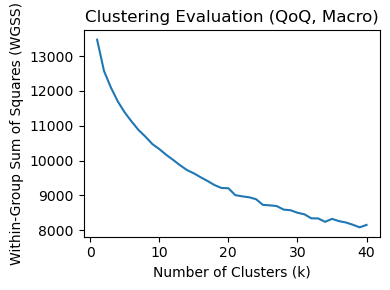

WGSS at 7 clusters: 10876


In [25]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (QoQ, Macro)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss[7])}')

#### Cluster by KPI and rate of change (QoQ, etc.)

In [26]:
# Create subset of KPI and Rate features; process for PCA
subset_df = pd.concat((get_KPI(dataset), get_Rate(dataset)), axis=1)
pca_df = process_for_PCA(subset_df)
X_PCA = pca.fit_transform(pca_df)

In [27]:
wgss = get_wgss(X_PCA, max_clusters=40)

100%|███████████████████████████████████████████| 40/40 [00:19<00:00,  2.07it/s]


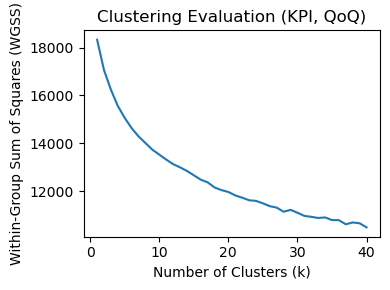

WGSS at 7 clusters: 14293


In [28]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (KPI, QoQ)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss[7])}')

## Analysis of Clustering by Different Subsets

The combination of key performance indicators (KPI) and macroeconomic variables yielded the best clustering performance as scored by the within-group sum of squares (WGSS).  This combination seems to be the best for clustering and assigning class labels using the K-Means method.  We should compare these results to what we find using hierarchical clustering.

The elbow plot for this combination (KPI + macro) did not result in a clear optimal number of clusters, but the gains in reduction of WGSS appeared to decline after about 30 clusters, depending on the run.  I noted a decent amount of variation between different runs, even using the best of 100 tries for each number of clusters to compensate for the variability of the K-Means algorithm.

## Visualize best clusters using PCA

In [29]:
# In the latest run, local optimums occurred at 14, 22, and 31 clusters
# We will re-run K-means using the selected subset for 10-40 clusters
# and choose the best clustering by WGSS
kmeans_fitted = {}
for n_clusters in tqdm(range(1, 41)):
    kmeans = KMeans(n_clusters, init='random', n_init=100, copy_x=False)
    kmeans.fit(X_KPI_macro_PCA)
    kmeans_fitted[n_clusters] = kmeans

100%|███████████████████████████████████████████| 40/40 [00:12<00:00,  3.11it/s]


In [30]:
wgss = {}
for i in range(1, 41):
    wgss[i] = kmeans_fitted[i].inertia_

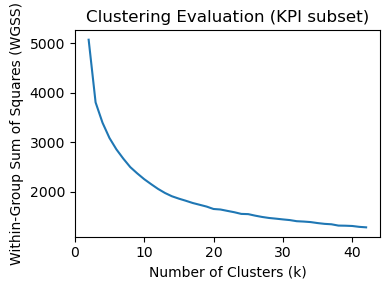

WGSS at 7 clusters: 2666


In [60]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (KPI subset)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss[7])}')

For this run, 7 clusters looks to be at the 'elbow' in the plot.

In [32]:
# Augment the (KPI + macro) subset with cluster labels
columns = ['PC' + str(i + 1) for i in range(X_KPI_macro_PCA.shape[1])]
labelled_PCA_df = pd.concat(
    (
        pd.DataFrame(X_KPI_macro_PCA, columns=columns), 
        dataset[['Sector', 'Market Cap', 'Ticker']].copy(),
        pd.Series(kmeans_fitted[7].labels_, name='Cluster')
    ), axis=1
)

In [33]:
# Plot PCA-transformed data along first two principal components
# Use cluster labels for color, Market Cap for shape
PCA_viz = alt.Chart(
    labelled_PCA_df,
    title=alt.Title(
        'PCA-transformed data',
        subtitle='(color indicates cluster assignment by K-Means (7 clusters)'
    )
).mark_point().encode(
    alt.X('PC1'),
    alt.Y('PC2'),
    color='Cluster:N',
    shape='Market Cap'
).properties(
    width=400,
    height=300
).configure_axis(
    grid=False
)

PCA_viz

alt.Chart(...)

### Plot with Cluster Centers

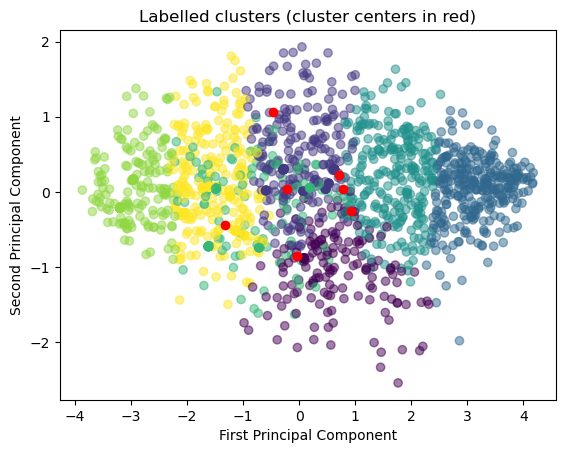

In [58]:
"""
# Set custom colors for each cluster
colors = ['green', 'blue', 'gray', 'purple', 'darkred', 'red', 'orange',
          'darkgreen', 'darkblue', 'darkgray', 'lightgreen', 'lightblue'
         ]
cmap = ListedColormap(colors)
"""
centroids = []
for centroid in kmeans_fitted[7].cluster_centers_:
    centroids.append(centroid[:2])
centroids = np.asarray(centroids)
PCA_scatter = plt.figure()
ax = PCA_scatter.subplots()
ax.scatter(x=labelled_PCA_df['PC1'],
           y=labelled_PCA_df['PC2'],
           c=labelled_PCA_df['Cluster'],
#           cmap=cmap,
           alpha=0.5
          )
ax.scatter(x=centroids[:, 0], y=centroids[:, 1], c='red')
ax.set_title('Labelled clusters (cluster centers in red)')
ax.set_ylabel('Second Principal Component')
ax.set_xlabel('First Principal Component')
plt.show()

## Visualization: Multi-Dimensional Scaling (MDS)

In [35]:
# Visualize in 2D using MDS
mds = MDS(n_init=1)
X_MDS = mds.fit_transform(X_KPI_macro_PCA)

/home/kp99/miniconda3/envs/MADS/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [36]:
# Use K-Means to assign cluster labels
n_clusters = 7
# kmeans = KMeans(n_clusters, init='random', n_init=100, copy_x=False)
cluster = kmeans_fitted[n_clusters].labels_

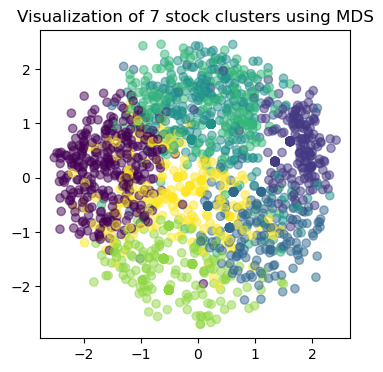

In [37]:
# Plot results
fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.scatter(X_MDS[:, 0], X_MDS[:, 1], c=cluster, alpha=0.5)
ax.set_title(f'Visualization of {n_clusters} stock clusters using MDS')
plt.show()

In [38]:
# Augment the MDS visualization with cluster labels
labelled_MDS_df = pd.concat(
    (
        pd.DataFrame(X_MDS, columns=['dimension 1', 'dimension 2']), 
        dataset[['Sector', 'Market Cap', 'Ticker']].copy(),
        pd.Series(cluster, name='Cluster')
    ), axis=1
)

In [39]:
# Plot PCA-transformed data along first two principal components
# Use cluster labels for color, Market Cap for shape
MDS_viz = alt.Chart(
    labelled_MDS_df,
    title=alt.Title(
        'Visualization of stock clusters using MDS',
        subtitle='(color indicates cluster assignment by K-Means (7 clusters)'
    )
).mark_point().encode(
    alt.X('dimension 1'),
    alt.Y('dimension 2'),
    color='Cluster:N',
    shape='Market Cap'
).properties(
    width=400,
    height=300
).configure_axis(
    grid=False
)

MDS_viz

alt.Chart(...)

## PCA on Fundamentals Only
## (no engineered features)

In [42]:
fundamental_df = pd.read_csv('../../datasets/X_train_filled.csv')
fundamental_df.shape

(1910, 109)

In [43]:
X_fundamental = process_for_PCA(fundamental_df)
pca = PCA()
X_fundamental_PCA = pca.fit_transform(X_fundamental)

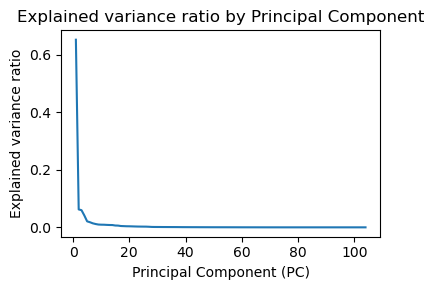

In [44]:
elbow_plot(
    data=np.asarray(
        [(i + 1, ratio) for i, ratio in enumerate(pca.explained_variance_ratio_)]
    ),
    title='Explained variance ratio by Principal Component',
    xlabel='Explained variance ratio',
    ylabel='Principal Component (PC)'
)

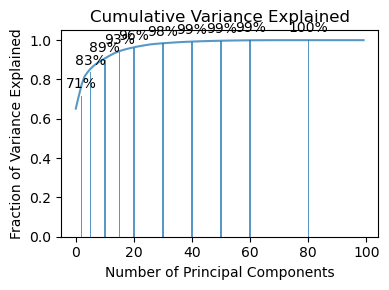

In [45]:
plot_cum_variance_explained(
    pca.explained_variance_ratio_,
    subset = [2, 5, 10, 15, 20, 30 , 40, 50, 60, 80],
    n=100
)

In [46]:
np.cumsum(pca.explained_variance_ratio_)[:20]

array([0.65180016, 0.71406047, 0.77362923, 0.81498199, 0.83579127,
       0.85356577, 0.86755003, 0.87909211, 0.88884305, 0.89809718,
       0.9071868 , 0.91569945, 0.9238254 , 0.93178771, 0.93816126,
       0.94423062, 0.94882966, 0.95303363, 0.95681359, 0.96044244])

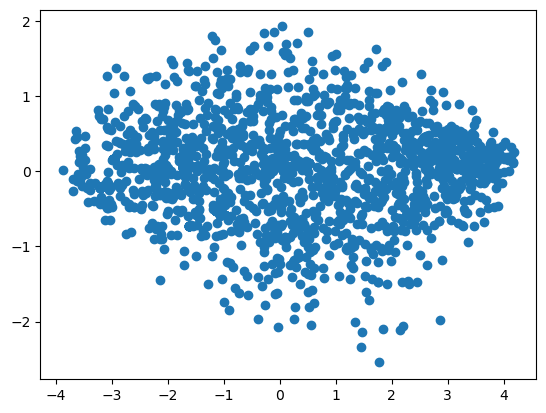

In [47]:
fig = plt.figure()
ax = fig.subplots()
ax.scatter(x=X_fundamental_PCA[:, 0], y=X_fundamental_PCA[:, 1])
plt.show()

In [48]:
kmeans_fitted_fundamental = {}
for n_clusters in tqdm(range(2, 43)):
    kmeans = KMeans(n_clusters, init='random', n_init=100, copy_x=False)
    kmeans.fit(X_fundamental_PCA[:, :10])
    kmeans_fitted_fundamental[n_clusters] = kmeans

100%|███████████████████████████████████████████| 41/41 [00:14<00:00,  2.92it/s]


In [49]:
wgss = {}
for i in range(2, 43):
    wgss[i] = kmeans_fitted_fundamental[i].inertia_

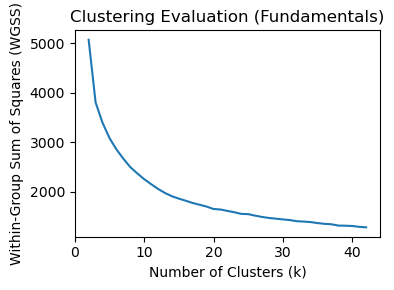

WGSS at 7 clusters: 2666


In [50]:
# Use results to make elbow plot
elbow_data = [(key, value) for key, value in wgss.items()]
elbow_plot(
    data=np.asarray(elbow_data),
    title='Clustering Evaluation (Fundamentals)',
    xlabel='Within-Group Sum of Squares (WGSS)',
    ylabel='Number of Clusters (k)'
)
print(f'WGSS at 7 clusters: {int(wgss[7])}')

In [51]:
# Augment the (KPI + macro) subset with cluster labels
columns = ['PC' + str(i + 1) for i in range(X_fundamental_PCA.shape[1])]
labelled_PCA_df = pd.concat(
    (
        pd.DataFrame(X_fundamental_PCA, columns=columns), 
        dataset[['Sector', 'Market Cap', 'Ticker']].copy(),
        pd.Series(kmeans_fitted_fundamental[7].labels_, name='Cluster')
    ), axis=1
)

In [52]:
# Plot PCA-transformed data along first two principal components
# Use cluster labels for color, Market Cap for shape
PCA_viz = alt.Chart(
    labelled_PCA_df,
    title=alt.Title(
        'PCA-transformed data',
        subtitle='(color indicates cluster assignment by K-Means (7 clusters)'
    )
).mark_point().encode(
    alt.X('PC1'),
    alt.Y('PC2'),
    color='Cluster:N',
    shape='Market Cap'
).properties(
    width=400,
    height=300
).configure_axis(
    grid=False
)

PCA_viz

alt.Chart(...)

In [53]:
# Visualize in 2D using MDS
mds = MDS(n_init=1)
X_fundamental_MDS = mds.fit_transform(X_fundamental_PCA)

In [54]:
# Use K-Means to assign cluster labels
n_clusters = 7
# kmeans = KMeans(n_clusters, init='random', n_init=100, copy_x=False)
cluster = kmeans_fitted_fundamental[n_clusters].labels_

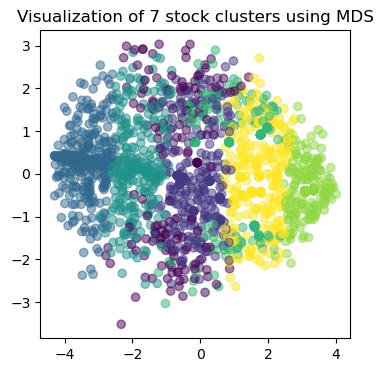

In [55]:
# Plot results
fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.scatter(X_fundamental_MDS[:, 0], X_fundamental_MDS[:, 1], c=cluster, alpha=0.5)
ax.set_title(f'Visualization of {n_clusters} stock clusters using MDS')
plt.show()

In [56]:
# Augment the MDS visualization with cluster labels
labelled_fundamental_MDS_df = pd.concat(
    (
        pd.DataFrame(X_fundamental_MDS, columns=['dimension 1', 'dimension 2']), 
        dataset[['Sector', 'Market Cap', 'Ticker']].copy(),
        pd.Series(cluster, name='Cluster')
    ), axis=1
)

In [57]:
# Plot PCA-transformed data along first two principal components
# Use cluster labels for color, Market Cap for shape
MDS_viz = alt.Chart(
    labelled_fundamental_MDS_df,
    title=alt.Title(
        'Visualization of stock clusters using MDS (fundamentals only)',
        subtitle='(color indicates cluster assignment by K-Means (7 clusters)'
    )
).mark_point().encode(
    alt.X('dimension 1'),
    alt.Y('dimension 2'),
    color='Cluster:N',
    shape='Market Cap'
).properties(
    width=400,
    height=300
).configure_axis(
    grid=False
)

MDS_viz

alt.Chart(...)